In [593]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

In [594]:
df = pd.read_csv('data.csv')

In [595]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [596]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-596-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-596-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-596-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [597]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [598]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-598-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-598-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [599]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_tr_cat)

ohe_x_train = ohe.transform(x_tr_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_tr_df = pd.DataFrame(ohe_x_train, columns=columns, index=x_tr.index)

In [600]:
combo_train_df = pd.concat([x_tr_cont, ohe_x_tr_df], axis=1)

In [601]:
combo_train_df.columns

Index(['year', 'household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed'],
      dtype='object')

In [602]:
combo_train_df['marital_status_Single/Never Married'].sum()

6075.0

In [603]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-603-b1430f2c33c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [604]:
x_train, x_val, y_train, y_val = train_test_split(combo_train_df, y_tr, test_size=.20, random_state=11)

In [605]:
y_train.drop(columns='bank_account',inplace=True)
y_val.drop(columns='bank_account',inplace=True)

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


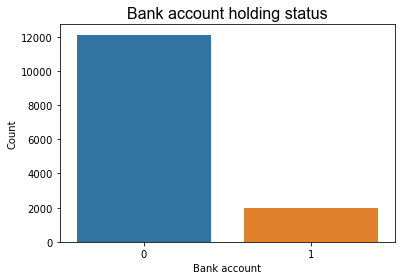

In [606]:
sns.countplot(x='bank_acc', data=y_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [607]:
count_no_acc = len(y_train[y_train['bank_acc']==0])
count_acc = len(y_train[y_train['bank_acc']==1])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.9288649567805
percentage of account 14.071135043219499


Classes are __very imbalanced__ - investigate threshold, over and undersampling

In [608]:
df_train = pd.concat([x_train,y_train],axis=1)
df_val = pd.concat([x_val,y_val],axis=1)

In [609]:
# Create dateframes to use for visualisations
df_vis_cont = pd.concat([x_tr_cont,y_tr],axis=1)
df_vis_cat = pd.concat([ohe_x_tr_df,y_tr],axis=1)

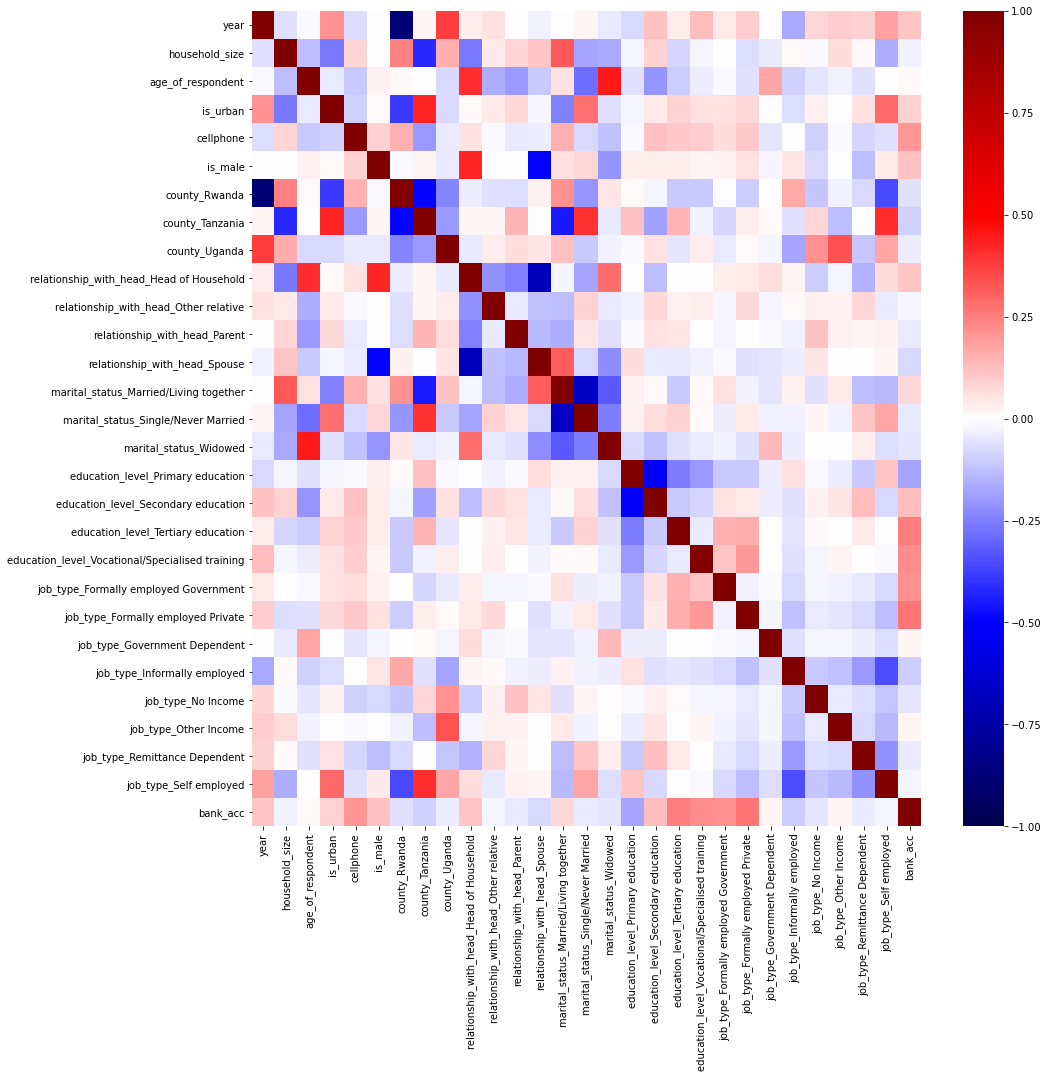

In [610]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), cmap="seismic", vmin=-1, vmax=1, ax=ax);

## Simple logistic regression

Testing with a single variable: is_male

In [611]:
#Model on is_male first
lm_1 = sm.Logit(df_train['bank_acc'],  # with statsmodels, `y` comes first
                sm.add_constant(df_train[['is_male']]))  # and then `x`
lm_1 = lm_1.fit()

Optimization terminated successfully.
         Current function value: 0.399382
         Iterations 6


In [612]:
lm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               bank_acc   No. Observations:                14114
Model:                          Logit   Df Residuals:                    14112
Method:                           MLE   Df Model:                            1
Date:                Mon, 01 Feb 2021   Pseudo R-squ.:                 0.01691
Time:                        20:32:31   Log-Likelihood:                -5636.9
converged:                       True   LL-Null:                       -5733.9
Covariance Type:            nonrobust   LLR p-value:                 4.398e-44
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1251      0.035    -60.055      0.000      -2.194      -2.056
is_male        0.6779      0.049     13.887      0.000       0.582       0.774
==============================================================================
"""

In [613]:
lm_1 = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm_1.fit(df_train[['is_male']], df_train['bank_acc'])

LogisticRegression(C=100000, solver='newton-cg')

In [614]:
print('intercept: ', round(lm_1.intercept_[0], 4))
print('is_male coef: ', round(lm_1.coef_[0][0], 4))

intercept:  -2.1251
is_male coef:  0.6779


In [615]:
df_eval = df_val.copy()
df_eval['pred'] = lm_1.predict(df_val[['is_male']])
df_eval.loc[:, 'pred'] = df_eval['pred'].astype('category')
df_eval['correct_pred'] = df_eval['pred'] == df_eval['bank_acc']

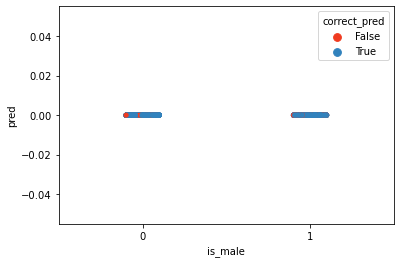

In [616]:
sns.stripplot(data=df_eval,
              x='is_male',
              y='pred',
              hue='correct_pred',
              palette={False: '#f03b20', True: '#3182bd'});

In [617]:
lm_1.predict_proba(df_val[['is_male']])[:5]

array([[0.89331742, 0.10668258],
       [0.80955703, 0.19044297],
       [0.89331742, 0.10668258],
       [0.89331742, 0.10668258],
       [0.80955703, 0.19044297]])

In [618]:
confusion_matrix(df_eval['bank_acc'], df_eval['pred'])

array([[3037,    0],
       [ 492,    0]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 3037 | 0|
| **is account (1)** | 492 | 0 |

I believe it is predicting all no account because of the following:
* Classes are very imbalanced (85:15 no account to account)
* One variable alone may not be sufficient enough in this instance
* Perhaps because is_male class is also imbalanced?

## Multiple regression
The below analysis is a multiple logistic regression for all features 

__IMPORTANT NOTES__: 
* Investigate adjusting the threshold given how imbalanced the classes are.
* Test feature interactions

In [619]:
features = ['household_size', 'age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [620]:
logit_model=sm.Logit(y_train1,x_train1)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.601423
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17030.9785
Date:               2021-02-01 20:32 BIC:              17234.9614
No. Observations:   14114            Log-Likelihood:   -8488.5   
Df Model:           26               LL-Null:          -5733.9   
Df Residuals:       14087            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        -0.0068     0.0223   -0.3028   0.7621   -0.0505    0.0370
x2         0.0787     0.0244    3.2231   0.0013    0.0308 

The below analysis includes all features. Thereafter the analyses remove insignificant features one by one.

In [621]:
lm_2 = LogisticRegression()
lm_2.fit(df_train[features], df_train['bank_acc'])

preds = lm_2.predict(df_val[features])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_2.score(df_val[features], y_val)))

Accuracy of logistic regression classifier on val set: 0.88


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [622]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [623]:
y_prob = lm_2.predict_proba(df_val[features])

In [624]:
confusion_matrix(df_val['bank_acc'], 
                 preds)

array([[2954,   83],
       [ 337,  155]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 2954 | 83|
| **is account (1)** | 337 | 155 |

Need to understand and decide on the __trade off between recall and precision__

Precision is the number of observations predicted positive over the total actual positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

The recall is the number of actually positive observations over the number predicted positive. The recall is intuitively the ability of the classifier to find all the positive samples.

In [625]:
from sklearn.metrics import classification_report
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3037
           1       0.65      0.32      0.42       492

    accuracy                           0.88      3529
   macro avg       0.77      0.64      0.68      3529
weighted avg       0.86      0.88      0.86      3529



In [626]:
df_val['proba_bank'] = lm_2.predict_proba(df_val[features])[:, 1]

fpr2, tpr2, thresholds2 = roc_curve(df_val['bank_acc'],
                                 df_val['proba_bank'])

In [627]:
def plot_roc(true, probas,fpr,tpr):
    auc = roc_auc_score(true, probas)

    plt.plot(fpr, tpr, marker='o')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 3)}");

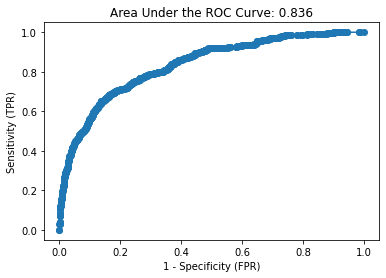

In [628]:
plot_roc(df_val['bank_acc'], df_val['proba_bank'],fpr2,tpr2)

## Adjusting threshold

In [629]:
threshold = .60
y_pred = np.where((y_prob[:, 0] > threshold),0,1)

In [630]:
confusion_matrix(df_val['bank_acc'], 
                 y_pred)

array([[2915,  122],
       [ 292,  200]])

## Multiple regression removing insignificant features one by one

## Removing household size

Based on logit summary above

In [631]:
x_train_3 = df_train.drop(columns = ['year', 'household_size'])

df_val_3 = df_val.drop(columns = ['year', 'household_size'])

In [632]:
features3 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Other relative',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [633]:
logit_model3=sm.Logit(df_train['bank_acc'],x_train_3[features3])
result=logit_model3.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.314047
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.227    
Dependent Variable:             bank_acc                   AIC:                        8916.9278
Date:                           2021-02-01 20:32           BIC:                        9113.3558
No. Observations:               14114                      Log-Likelihood:             -4432.5  
Df Model:                       25                         LL-Null:                    -5733.9  
Df Residuals:                   14088                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [634]:
lm_3 = LogisticRegression()
lm_3.fit(x_train_3[features3], x_train_3['bank_acc'])

preds3 = lm_3.predict(df_val_3[features3])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_3.score(df_val_3[features3], df_val_3['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [635]:
confusion_matrix(df_val_3['bank_acc'], 
                 preds3)

array([[2963,   74],
       [ 327,  165]])

Essentially no change in precision and recall when household size is removed

In [636]:
print(classification_report(df_val_3['bank_acc'], preds3))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.69      0.34      0.45       492

    accuracy                           0.89      3529
   macro avg       0.80      0.66      0.69      3529
weighted avg       0.87      0.89      0.87      3529



## Removing relationship with head - Other 

Based on logit summary above. Note each iteration is building off the previous

In [637]:
x_train_4 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative'])

df_val_4 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative'])

In [638]:
features4 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Parent', 'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [639]:
logit_model4=sm.Logit(x_train_4['bank_acc'],x_train_4[features4])
result=logit_model4.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.315935
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.222    
Dependent Variable:             bank_acc                   AIC:                        8968.2273
Date:                           2021-02-01 20:32           BIC:                        9157.1003
No. Observations:               14114                      Log-Likelihood:             -4459.1  
Df Model:                       24                         LL-Null:                    -5733.9  
Df Residuals:                   14089                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [640]:
lm_4 = LogisticRegression()
lm_4.fit(x_train_4[features4], x_train_4['bank_acc'])

preds4 = lm_4.predict(df_val_4[features4])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_4.score(df_val_4[features4],df_val_4['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.886


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [641]:
confusion_matrix(df_val_4['bank_acc'], 
                 preds4)

array([[2957,   80],
       [ 322,  170]])

Minor (1) improvement in predictions for both account and non-account holders

In [642]:
print(classification_report(df_val_4['bank_acc'], preds4))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.68      0.35      0.46       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [643]:
df_val_4['proba_bank'] = lm_4.predict_proba(df_val_4[features4])[:, 1]

fpr4, tpr4, thresholds4 = roc_curve(df_val_4['bank_acc'],
                                 df_val_4['proba_bank'])

In [644]:
auc4 = roc_auc_score(df_val_4['bank_acc'], df_val_4['proba_bank'])
print('AUC: %.3f' % auc4)

AUC: 0.839


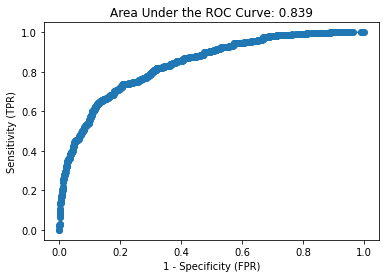

In [645]:
plot_roc(df_val_4['bank_acc'], df_val_4['proba_bank'],fpr4,tpr4)

## Removing relationship with head - Parent 

Based on logit summary above

In [646]:
x_train_5 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent'])

df_val_5 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent'])

features5 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married', 'marital_status_Widowed',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [647]:
logit_model5=sm.Logit(x_train_5['bank_acc'],x_train_5[features5])
result=logit_model5.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.317599
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.218    
Dependent Variable:             bank_acc                   AIC:                        9013.1901
Date:                           2021-02-01 20:32           BIC:                        9194.5083
No. Observations:               14114                      Log-Likelihood:             -4482.6  
Df Model:                       23                         LL-Null:                    -5733.9  
Df Residuals:                   14090                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [648]:
lm_5 = LogisticRegression()
lm_5.fit(x_train_5[features5], x_train_5['bank_acc'])

preds5 = lm_5.predict(df_val_5[features5])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_5.score(df_val_5[features5], df_val_5['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.887


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [649]:
confusion_matrix(df_val_5['bank_acc'], 
                 preds5)

array([[2960,   77],
       [ 323,  169]])

No change from the results above

In [650]:
print(classification_report(df_val_5['bank_acc'], preds5))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.69      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.79      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



## Removing marital status - widowed

Based on logit summary above

In [651]:
x_train_6 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed'])

df_val_6 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed'])

features6 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Other Income', 'job_type_Remittance Dependent',
       'job_type_Self employed']

In [652]:
logit_model6=sm.Logit(x_train_6['bank_acc'],x_train_6[features6])
result6=logit_model6.fit()
print(result6.summary2())

Optimization terminated successfully.
         Current function value: 0.319210
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.214    
Dependent Variable:             bank_acc                   AIC:                        9056.6465
Date:                           2021-02-01 20:32           BIC:                        9230.4098
No. Observations:               14114                      Log-Likelihood:             -4505.3  
Df Model:                       22                         LL-Null:                    -5733.9  
Df Residuals:                   14091                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [653]:
lm_6 = LogisticRegression()
lm_6.fit(x_train_6[features6], x_train_6['bank_acc'])

preds6 = lm_6.predict(df_val_6[features6])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_6.score(df_val_6[features6], df_val_6['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.885


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [654]:
confusion_matrix(df_val_6['bank_acc'], 
                 preds6)

array([[2954,   83],
       [ 324,  168]])

Minor (1) improvement in prediction of account holders with the removal of widows

In [655]:
print(classification_report(df_val_6['bank_acc'], preds6))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94      3037
           1       0.67      0.34      0.45       492

    accuracy                           0.88      3529
   macro avg       0.79      0.66      0.69      3529
weighted avg       0.87      0.88      0.87      3529



## Removing remittance / no income 

Based on logit summary above. HOWEVER, consider merging these two and adding as a new column

In [661]:
x_train_7 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed',
                                    'job_type_Other Income'])

df_val_7 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed',
                                 'job_type_Other Income'])

features7 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed',
       'job_type_No Income',
        'job_type_Remittance Dependent',
       'job_type_Self employed']

In [662]:
x_train_7.columns

Index(['age_of_respondent', 'is_urban', 'cellphone', 'is_male',
       'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed', 'job_type_No Income',
       'job_type_Remittance Dependent', 'job_type_Self employed', 'bank_acc'],
      dtype='object')

In [663]:
logit_model7=sm.Logit(x_train_7['bank_acc'],x_train_7[features7])
result7=logit_model7.fit()
print(result7.summary2())

Optimization terminated successfully.
         Current function value: 0.319235
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.214    
Dependent Variable:             bank_acc                   AIC:                        9055.3548
Date:                           2021-02-01 20:33           BIC:                        9221.5631
No. Observations:               14114                      Log-Likelihood:             -4505.7  
Df Model:                       21                         LL-Null:                    -5733.9  
Df Residuals:                   14092                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [665]:
lm_7 = LogisticRegression()
lm_7.fit(x_train_7[features7], x_train_7['bank_acc'])

preds7 = lm_7.predict(df_val_7[features7])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_7.score(df_val_7[features7], df_val_7['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.883


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [666]:
confusion_matrix(df_val_7['bank_acc'], 
                 preds7)

array([[2959,   78],
       [ 334,  158]])

Minor (1) drop in prediction of account holders with removal of remittance dependent / no income

In [667]:
print(classification_report(df_val_7['bank_acc'], preds7))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3037
           1       0.67      0.32      0.43       492

    accuracy                           0.88      3529
   macro avg       0.78      0.65      0.68      3529
weighted avg       0.87      0.88      0.87      3529



## Removing spouse

Based on logit summary above

In [671]:
x_train_8 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed',
                                    'job_type_Other Income','relationship_with_head_Spouse'])

df_val_8 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed',
                                 'job_type_Other Income','relationship_with_head_Spouse'])

features8 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed',
       'job_type_No Income',
        'job_type_Remittance Dependent',
       'job_type_Self employed']

In [672]:
logit_model8=sm.Logit(x_train_8['bank_acc'],x_train_8[features8])
result8=logit_model8.fit()
print(result8.summary2())

Optimization terminated successfully.
         Current function value: 0.319270
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.214    
Dependent Variable:             bank_acc                   AIC:                        9054.3615
Date:                           2021-02-01 20:41           BIC:                        9213.0149
No. Observations:               14114                      Log-Likelihood:             -4506.2  
Df Model:                       20                         LL-Null:                    -5733.9  
Df Residuals:                   14093                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [674]:
lm_8 = LogisticRegression()
lm_8.fit(x_train_8[features8], x_train_8['bank_acc'])

preds8 = lm_8.predict(df_val_8[features8])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_8.score(df_val_8[features8], df_val_8['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.885


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [675]:
confusion_matrix(df_val_8['bank_acc'], 
                 preds8)

array([[2963,   74],
       [ 331,  161]])

Minor improvement in recall for non-account but decrease in recall for account

In [676]:
print(classification_report(df_val_8['bank_acc'], preds8))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.69      0.33      0.44       492

    accuracy                           0.89      3529
   macro avg       0.79      0.65      0.69      3529
weighted avg       0.87      0.89      0.87      3529



## Removing self employed

Based on logit summary above

In [677]:
x_train_9 = df_train.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                     'relationship_with_head_Parent','marital_status_Widowed',
                                    'job_type_Other Income','relationship_with_head_Spouse','job_type_Self employed'])

df_val_9 = df_val.drop(columns = ['year', 'household_size','relationship_with_head_Other relative',
                                  'relationship_with_head_Parent','marital_status_Widowed',
                                 'job_type_Other Income','relationship_with_head_Spouse','job_type_Self employed'])

features9 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'marital_status_Married/Living together',
       'marital_status_Single/Never Married',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Informally employed',
       'job_type_No Income',
        'job_type_Remittance Dependent']

In [678]:
logit_model9=sm.Logit(x_train_9['bank_acc'],x_train_9[features9])
result9=logit_model9.fit()
print(result9.summary2())

Optimization terminated successfully.
         Current function value: 0.319317
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.214    
Dependent Variable:             bank_acc                   AIC:                        9053.6708
Date:                           2021-02-01 20:44           BIC:                        9204.7693
No. Observations:               14114                      Log-Likelihood:             -4506.8  
Df Model:                       19                         LL-Null:                    -5733.9  
Df Residuals:                   14094                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [679]:
lm_9 = LogisticRegression()
lm_9.fit(x_train_9[features9], x_train_9['bank_acc'])

preds9 = lm_9.predict(df_val_9[features9])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_9.score(df_val_9[features9], df_val_9['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.883


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [681]:
confusion_matrix(df_val_9['bank_acc'], 
                 preds9)

array([[2958,   79],
       [ 333,  159]])

No change in recall for non-account but minor improvement in recall for account

In [682]:
print(classification_report(df_val_9['bank_acc'], preds9))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3037
           1       0.67      0.32      0.44       492

    accuracy                           0.88      3529
   macro avg       0.78      0.65      0.69      3529
weighted avg       0.87      0.88      0.87      3529



## Adding female head hh interaction

In [688]:
x_train_10 = x_train_9.copy()
df_val_10 = df_val_9.copy()

x_train_10['female_hh'] = np.where((x_train_10['is_male'] == 0) & 
                                   (x_train_10['relationship_with_head_Head of Household']==1),
                                  1,0)

df_val_10['female_hh'] = np.where((df_val_10['is_male'] == 0) & (df_val_10['relationship_with_head_Head of Household']==1),
                                  1,0)

features10 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'marital_status_Married/Living together',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_No Income', 'job_type_Remittance Dependent','female_hh']

In [689]:
logit_model10=sm.Logit(x_train_10['bank_acc'],x_train_10[features10])
result10=logit_model10.fit()
print(result10.summary2())

Optimization terminated successfully.
         Current function value: 0.327756
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.193    
Dependent Variable:             bank_acc                   AIC:                        9289.8892
Date:                           2021-02-01 20:47           BIC:                        9433.4327
No. Observations:               14114                      Log-Likelihood:             -4625.9  
Df Model:                       18                         LL-Null:                    -5733.9  
Df Residuals:                   14095                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [690]:
lm_10 = LogisticRegression()
lm_10.fit(x_train_10[features10], x_train_10['bank_acc'])

preds10 = lm_10.predict(df_val_10[features10])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_10.score(df_val_10[features10], df_val_10['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.883


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [691]:
confusion_matrix(df_val_10['bank_acc'], 
                 preds10)

array([[2968,   69],
       [ 343,  149]])

In [692]:
print(classification_report(df_val_10['bank_acc'], preds10))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.68      0.30      0.42       492

    accuracy                           0.88      3529
   macro avg       0.79      0.64      0.68      3529
weighted avg       0.87      0.88      0.86      3529



In [693]:
df_val_10['proba_bank'] = lm_10.predict_proba(df_val_10[features10])[:, 1]

fpr10, tpr10, thresholds10 = roc_curve(df_val_10['bank_acc'],
                                 df_val_10['proba_bank'])

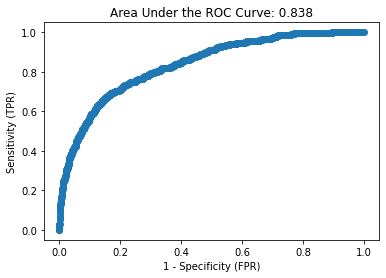

In [694]:
plot_roc(df_val_10['bank_acc'], df_val_10['proba_bank'],fpr10,tpr10)

In [705]:
lm_10.coef_

array([[ 0.01537416,  0.36979782,  1.62801462, -0.20781145, -0.40644897,
        -1.05800023, -0.73452223,  0.96579578,  0.17370093,  0.63818275,
         1.65058827,  3.05090062,  2.66071265,  1.62035109,  1.53084254,
         0.90185455, -0.49055131, -0.33436406, -0.68129772]])

## Adding rural and primary education interaction

In [698]:
x_train_11 = x_train_9.copy()
df_val_11 = df_val_9.copy()

x_train_11['rural_primary'] = np.where((x_train_11['is_urban'] == 0) & 
                                   (x_train_11['education_level_Primary education']==1),
                                  1,0)

df_val_11['rural_primary'] = np.where((df_val_11['is_urban'] == 0) & (df_val_11['education_level_Primary education']==1),
                                  1,0)

features11 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'marital_status_Married/Living together',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_No Income', 'job_type_Remittance Dependent','rural_primary']

In [699]:
logit_model11=sm.Logit(x_train_11['bank_acc'],x_train_11[features11])
result11=logit_model11.fit()
print(result11.summary2())

Optimization terminated successfully.
         Current function value: 0.334140
         Iterations 7
                                         Results: Logit
Model:                          Logit                      Pseudo R-squared:           0.178    
Dependent Variable:             bank_acc                   AIC:                        9470.0963
Date:                           2021-02-01 20:52           BIC:                        9613.6398
No. Observations:               14114                      Log-Likelihood:             -4716.0  
Df Model:                       18                         LL-Null:                    -5733.9  
Df Residuals:                   14095                      LLR p-value:                0.0000   
Converged:                      1.0000                     Scale:                      1.0000   
No. Iterations:                 7.0000                                                          
------------------------------------------------------------------

In [700]:
lm_11 = LogisticRegression()
lm_11.fit(x_train_11[features11], x_train_11['bank_acc'])

preds11 = lm_11.predict(df_val_11[features11])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_11.score(df_val_11[features11], df_val_11['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.881


/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [486]:
confusion_matrix(df_val_11['bank_acc'], 
                 preds11)

array([[2963,   74],
       [ 325,  167]])

In [701]:
print(classification_report(df_val_11['bank_acc'], preds11))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3037
           1       0.66      0.31      0.42       492

    accuracy                           0.88      3529
   macro avg       0.78      0.64      0.68      3529
weighted avg       0.86      0.88      0.86      3529



In [702]:
df_val_11['proba_bank'] = lm_11.predict_proba(df_val_11[features11])[:, 1]

fpr11, tpr11, thresholds11 = roc_curve(df_val_11['bank_acc'],
                                 df_val_11['proba_bank'])

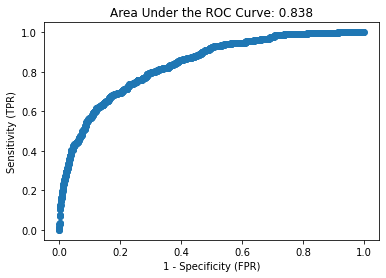

In [703]:
plot_roc(df_val_11['bank_acc'], df_val_11['proba_bank'],fpr11,tpr11)

## Removing married / living together

In [490]:
x_train_12 = x_train_11.drop(columns='marital_status_Married/Living together')

df_val_12 = df_val_11.drop(columns='marital_status_Married/Living together')

features12 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [491]:
scaler12 = StandardScaler()
x_train12 = scaler12.fit_transform(x_train_12[features12])
y_train12 = df_train['bank_acc']

In [492]:
logit_model12=sm.Logit(y_train12,x_train12)
result12=logit_model12.fit()
print(result12.summary2())

Optimization terminated successfully.
         Current function value: 0.601299
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.480    
Dependent Variable: bank_acc         AIC:              17013.4704
Date:               2021-02-01 19:54 BIC:              17164.5688
No. Observations:   14114            Log-Likelihood:   -8486.7   
Df Model:           19               LL-Null:          -5733.9   
Df Residuals:       14094            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0909     0.0226     4.0246   0.0001    0.0466    0.1351
x2        0.1565     0.0297     5.2770   0.0000    0.0984 

In [493]:
lm_12 = LogisticRegression()
lm_12.fit(x_train12, y_train12)

x_val12 = scaler12.transform(df_val_12[features12])
preds12 = lm_12.predict(x_val12)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_12.score(x_val12, y_val)))

Accuracy of logistic regression classifier on val set: 0.89


In [494]:
confusion_matrix(df_val['bank_acc'], 
                 preds12)

array([[2962,   75],
       [ 324,  168]])

In [495]:
print(classification_report(y_val, preds12))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3037
           1       0.69      0.34      0.46       492

    accuracy                           0.89      3529
   macro avg       0.80      0.66      0.70      3529
weighted avg       0.87      0.89      0.87      3529



In [496]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

In [501]:
df_val_12['proba_bank'] = lm_12.predict_proba(df_val_12[features12])[:, 1]

fpr12, tpr12, thresholds12 = roc_curve(df_val_12['bank_acc'],
                                 df_val_12['proba_bank'])

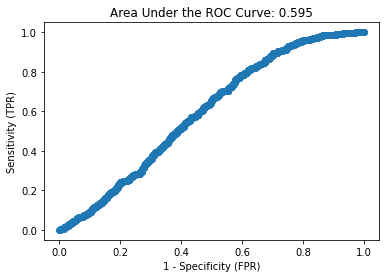

In [499]:
plot_roc(df_val_12['bank_acc'], df_val_12['proba_bank'],fpr12,tpr12)

In [500]:
# calculate F1 score
f1_12 = f1_score(df_val_12['bank_acc'], preds12)
print('F1 score for model 12:')
f1_12

F1 score for model 12:


0.45714285714285713

## Model 12 - Adjusting threshold

In [502]:
y_prob_12t = lm_12.predict_proba(x_val12)

In [505]:
threshold12 = .86
y_pred12 = np.where((y_prob_12t[:, 0] > threshold12),0,1)

In [506]:
confusion_matrix(df_val_12['bank_acc'], 
                 y_pred12)

array([[2444,  593],
       [ 138,  354]])

In [ ]:
df_val_12['proba_bank'] = lm_12.predict_proba(df_val_12[features12])[:, 1]

fpr12, tpr12, thresholds12 = roc_curve(df_val_12['bank_acc'],
                                 df_val_12['proba_bank'])

In [533]:
f1_12 = f1_score(df_val_12['bank_acc'], y_pred12)
print('F1 score for model 12 with oversampling: {:.3f}'.format(f1_12))

F1 score for model 12 with oversampling: 0.492


# Model 12 - Oversampling minority class in train

In [507]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(x_train_12[features12], df_train['bank_acc'])

In [508]:
from collections import Counter
Counter(y_resampled)

Counter({0: 12128, 1: 12128})

In [342]:
#df_val_12_re = df_val_12.drop(columns=['proba_bank'])

In [526]:
lm_12_1 = LogisticRegression()
lm_12_1.fit(X_resampled, y_resampled)

preds12_1 = lm_12_1.predict(df_val_12_re[features12])
print('Accuracy of logistic regression classifier on val set: {:.3f}'.format(
    lm_12_1.score(df_val_12_re[features12], df_val_12_re['bank_acc'])))

Accuracy of logistic regression classifier on val set: 0.793


In [527]:
confusion_matrix(df_val_12_re['bank_acc'], 
                 preds12_1)

array([[2447,  590],
       [ 139,  353]])

In [528]:
print(classification_report(df_val_12_re['bank_acc'], preds12_1))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      3037
           1       0.37      0.72      0.49       492

    accuracy                           0.79      3529
   macro avg       0.66      0.76      0.68      3529
weighted avg       0.87      0.79      0.82      3529



In [529]:
f1_12_1 = f1_score(df_val_12_re['bank_acc'], preds12_1)
print('F1 score for model 12 with oversampling: {:.3f}'.format(f1_12_1))

F1 score for model 12 with oversampling: 0.492


In [530]:
df_val_12_re['proba_bank'] = lm_12_1.predict_proba(df_val_12_re[features12])[:, 1]

fpr_12o, tpr_12o, thresholds_12o = roc_curve(df_val_12_re['bank_acc'],
                                 df_val_12_re['proba_bank'])

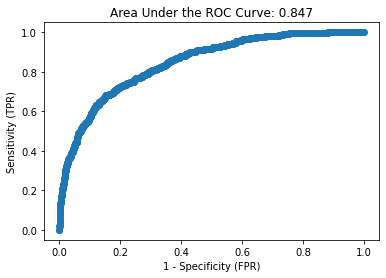

In [531]:
plot_roc(df_val_12_re['bank_acc'],df_val_12_re['proba_bank'],fpr_12o,tpr_12o)

## Removing secondary education

In [104]:
x_train_13 = x_train_12.drop(columns='education_level_Secondary education')

df_val_13 = df_val_12.drop(columns='education_level_Secondary education')

features13 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [105]:
scaler13 = StandardScaler()
x_train13 = scaler13.fit_transform(x_train_13[features13])
y_train13 = df_train['bank_acc']

In [106]:
logit_model13=sm.Logit(y_train13,x_train13)
result13=logit_model13.fit()
print(result13.summary2())

Optimization terminated successfully.
         Current function value: 0.605012
         Iterations 8
                         Results: Logit
Model:              Logit            Pseudo R-squared: -0.489    
Dependent Variable: bank_acc         AIC:              17116.2881
Date:               2021-02-01 07:58 BIC:              17259.8316
No. Observations:   14114            Log-Likelihood:   -8539.1   
Df Model:           18               LL-Null:          -5733.9   
Df Residuals:       14095            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     8.0000                                       
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
x1        0.0332     0.0217     1.5293   0.1262   -0.0094    0.0758
x2        0.1910     0.0292     6.5359   0.0000    0.1337 

In [107]:
lm_13 = LogisticRegression()
lm_13.fit(x_train13, y_train13)

x_val13 = scaler13.transform(df_val_13[features13])
preds13 = lm_13.predict(x_val13)
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_13.score(x_val13, y_val)))

Accuracy of logistic regression classifier on val set: 0.88


In [108]:
confusion_matrix(df_val['bank_acc'], 
                 preds13)

array([[2963,   74],
       [ 338,  154]])

In [109]:
print(classification_report(y_val, preds13))

              precision    recall  f1-score   support

           0       0.90      0.98      0.93      3037
           1       0.68      0.31      0.43       492

    accuracy                           0.88      3529
   macro avg       0.79      0.64      0.68      3529
weighted avg       0.87      0.88      0.86      3529



Note the model does better at predicting WITH secondary education and therefore I should __not use this model__

## Testing the model on the test set

Note the first analysis is based on the first multiple regression model above (including all features, no interactions)

1. Preparing the test sample 

In [117]:
x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
x_test['is_male'] = np.where(x_test['gender_of_respondent'] == 'Male',1,0)

<ipython-input-117-120e2e6065ba>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['is_urban'] = np.where(x_test['location_type'] == 'Urban',1,0)
<ipython-input-117-120e2e6065ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['cellphone'] = np.where(x_test['cellphone_access'] == 'Yes',1,0)
<ipython-input-117-120e2e6065ba>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [118]:
x_test_cont = x_test[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_test_cat = x_test[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [119]:
x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_test_cat.loc[x_test_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_test_cat.loc[x_test_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_test_cat.loc[x_test_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-119-c58a8d9a8085>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_cat.loc[x_test_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-119-c58a8d9a8085>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [120]:
ohe = OneHotEncoder(drop='first', sparse=False)

ohe.fit(x_test_cat)

ohe_x_test = ohe.transform(x_test_cat)

columns = ohe.get_feature_names(['county','relationship_with_head', 'marital_status',
       'education_level', 'job_type'])

ohe_x_test_df = pd.DataFrame(ohe_x_test, columns=columns, index=x_test.index)

In [121]:
combo_test_df = pd.concat([x_test_cont, ohe_x_test_df], axis=1)

In [122]:
y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
y_test.drop(columns='bank_account',inplace=True)
df_test = pd.concat([combo_test_df,y_test],axis=1)

<ipython-input-122-52765b19127d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['bank_acc'] = np.where(y_test['bank_account'] == 'Yes', 1,0)
/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


2. Testing the model on the test sample

In [329]:
x_test1 = scaler.transform(df_test[features])
preds1_test = lm_2.predict(x_test1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lm_2.score(x_test1, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [330]:
confusion_matrix(df_test['bank_acc'], 
                 preds1_test)

array([[4897,  150],
       [ 543,  291]])


| | predict No account (0) | predict account (1)|
|---|---|---|
| **is no account (0)** | 4839 | 149|
| **is account (1)** | 543 | 291 |

Need to do the following:
* Check error metrics
* Conduct cross validation
* Test with other classification models 

In [331]:
print(classification_report(y_test, preds1_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5047
           1       0.66      0.35      0.46       834

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.70      5881
weighted avg       0.87      0.88      0.87      5881



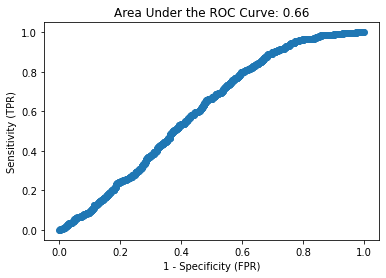

In [332]:
plot_roc(df_test['bank_acc'], preds1_test)

## Multiple regression with model 12

In [127]:
df_test_12 = df_test.drop(columns= ['year', 'household_size','marital_status_Married/Living together',
                          'relationship_with_head_Other relative',
                          'relationship_with_head_Parent','marital_status_Widowed','job_type_Remittance Dependent',
                         'job_type_No Income'])


df_test_12['female_hh'] = np.where((df_test_12['is_male'] == 0) & 
                                   (df_test_12['relationship_with_head_Head of Household']==1),
                                  1,0)

df_test_12['rural_primary'] = np.where((df_test_12['is_urban'] == 0) & 
                                   (df_test_12['education_level_Primary education']==1),
                                  1,0)

features12 = ['age_of_respondent', 'is_urban', 'cellphone',
       'is_male', 'county_Rwanda', 'county_Tanzania', 'county_Uganda',
       'relationship_with_head_Head of Household',
       'relationship_with_head_Spouse',
       'education_level_Primary education',
       'education_level_Secondary education',
       'education_level_Tertiary education',
       'education_level_Vocational/Specialised training',
       'job_type_Formally employed Government',
       'job_type_Formally employed Private', 'job_type_Government Dependent',
       'job_type_Other Income',
       'job_type_Self employed','female_hh','rural_primary']

In [128]:
x_test12 = scaler12.transform(df_test_12[features12])
preds12_test = lm_12.predict(x_test12)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lm_12.score(x_test12, y_test)))

Accuracy of logistic regression classifier on test set: 0.88


In [129]:
confusion_matrix(df_test_12['bank_acc'], 
                 preds12_test)

array([[4899,  148],
       [ 546,  288]])

In [130]:
print(classification_report(y_test, preds12_test))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      5047
           1       0.66      0.35      0.45       834

    accuracy                           0.88      5881
   macro avg       0.78      0.66      0.69      5881
weighted avg       0.87      0.88      0.87      5881



Model is broadly consistent across train - val - test

## With oversampling

In [326]:
preds12_1_test = lm_12_1.predict(df_test_12[features12])
print('Accuracy of logistic regression classifier on val set: {:.2f}'.format(lm_12_1.score(df_test_12[features12], y_test)))

Accuracy of logistic regression classifier on val set: 0.79


In [327]:
confusion_matrix(df_test_12['bank_acc'], 
                 preds12_1_test)

array([[4034, 1013],
       [ 223,  611]])

In [353]:
df_test_12['proba_bank'] = lm_12_1.predict_proba(df_test_12[features12])[:, 1]

fpr_test12, tpr_test12, thresholds_test12 = roc_curve(df_test_12['bank_acc'],
                                 df_test_12['proba_bank'])

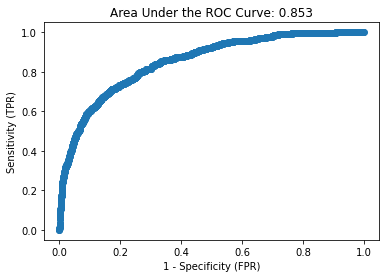

In [375]:
plot_roc(df_test_12['bank_acc'], df_test_12['proba_bank'],fpr_test12,tpr_test12)

In [358]:
f1_12_1_test = f1_score(df_test_12['bank_acc'], preds12_1_test)
print('F1 score for model 12 with oversampling:')
f1_12_1_test

F1 score for model 12 with oversampling:


0.4971521562245729

In [349]:
lr_auc = roc_auc_score(df_test_12['bank_acc'], df_test_12['proba_bank'])

In [350]:
lr_auc

0.8530040639570768